# Battery Consumption and Driving Range 

<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Available-Data-and-Methodology" data-toc-modified-id="Available-Data-and-Methodology-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Available Data and Methodology</a></span><ul class="toc-item"><li><span><a href="#Simple-Moving-Median-(SMM)" data-toc-modified-id="Simple-Moving-Median-(SMM)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple Moving Median (SMM)</a></span></li><li><span><a href="#Median-value-at-a-constant-velocity" data-toc-modified-id="Median-value-at-a-constant-velocity-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Median value at a constant velocity</a></span></li></ul></li><li><span><a href="#Method-Comparison" data-toc-modified-id="Method-Comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method Comparison</a></span><ul class="toc-item"><li><span><a href="#Battery-consumption-per-100-km" data-toc-modified-id="Battery-consumption-per-100-km-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Battery consumption per 100 km</a></span></li><li><span><a href="#Drive-Range" data-toc-modified-id="Drive-Range-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Drive Range</a></span></li></ul></li><li><span><a href="#Vehicle-Comparison" data-toc-modified-id="Vehicle-Comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Vehicle Comparison</a></span><ul class="toc-item"><li><span><a href="#Consumption" data-toc-modified-id="Consumption-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Consumption</a></span></li><li><span><a href="#Drive-Range" data-toc-modified-id="Drive-Range-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Drive Range</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, warnings
sys.path.append('../chargecurve/')
warnings.filterwarnings('ignore')
from databases import load_base2_ftp, query_station
from functions import get_peaks, collect_drives
from chargecurve import AutoDrive, DriveCurve
import datetime

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

##load data
hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select drive data
mask = (hyundai.speed > 1) & (hyundai.hvBatteryCurrent != 1) 
hyundai_drives = collect_drives(hyundai[mask])
HyundaiDriveCurve = DriveCurve(hyundai_drives)

## Introduction

In this notebook we will determine the energy consumption and drive range of the battery with the help of real drive data.

To achieve that, we will need to develop a model that correlates the velocity of the vehicle with the power consumption of the battery. The goal here will be, to determine the energy consumption of the battery at a fixed vehicle velocity.

## Available Data and Methodology

The drive data that we have available are depicted in the graph below (blue points). Each of these points corresponds to measurements of the power consumed by the battery at a given velocity in a time interval of 20 seconds. As observed in the figure, the data is rather scattered, this is due to the fact that, the data has been collected at different drive events under different driving conditions. 

An accurate model of the power consumption will consider all possible drive conditions such as, air and battery temperature, altitude, wind resistance, etc. This however, requires more data that the one currently available. Still the idea is to implement all this parameters in the future once more data is available.

In this report, a first approach to this problem is presented. We will develop a general model that provides a relationship between vehicle's velocity and battery consumption. To do so, we need to first identify a dependency between these parameters. Due to the scattered nature of the data, we must first find the way to 'simplify' it or smooth it, in order to further consider a mathematical approach. To do that, we will consider two methods, the median, and the rolling median (aka., simple moving median).


### Simple Moving Median (SMM)

In statistics, a moving average (in our case median) is a calculation to analyze data points by creating a series of medians of different subsets of the full data set. For example, we subset our data set with a window of 30 data points. We now, calculate the median for this subset, then we move ('moving') this window one point and repeat the process. This is done iteratively throughout the whole dataset.

Below is a example of applying the SMM method to our Consumed power vs. Speed data (yellow points).

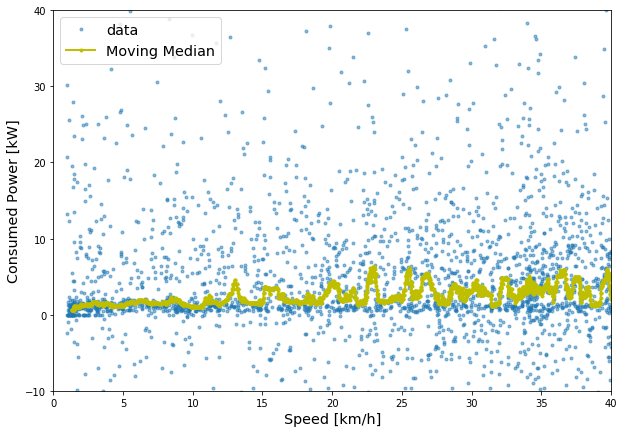

In [4]:
plt.figure(figsize=(10,7))
plt.plot(HyundaiDriveCurve.data.Speed, HyundaiDriveCurve.data.PowerConsumptionNet, '.', alpha = 0.5, label='data')
plt.plot(HyundaiDriveCurve.data.Speed, HyundaiDriveCurve.data.PowerConsumptionNet.rolling(50).median(), '.-', c='y', lw=2, label='Moving Median')
plt.legend(fontsize='x-large')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylabel('Consumed Power [kW]', fontsize='x-large')
plt.xlim(0,40)
plt.ylim(-10,40);

### Median value at a constant velocity 

In the second method, we calculate the median value at a given velocity. To do that, we aggregate the data in velocity bins or windows of 1km/h widths. For example, we aggregate all power values in the range between 0 and 1 km/h and calculate the median. Then we do the same for the power values between  1 and 2 km/h, etc.

Below is an example of this method applied to our data.

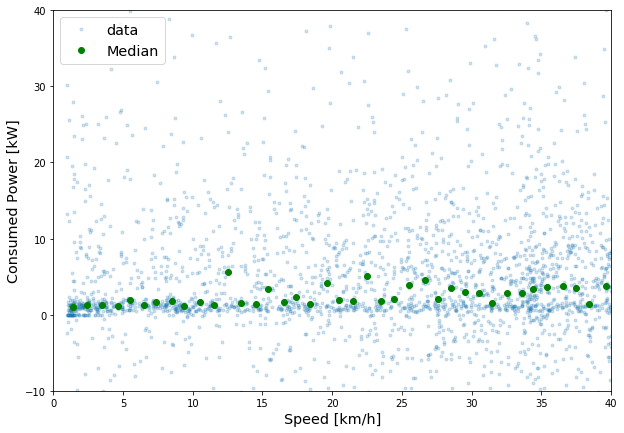

In [5]:
medians = HyundaiDriveCurve.getMedianBins()

plt.figure(figsize=(10,7))
plt.plot(HyundaiDriveCurve.data.Speed, HyundaiDriveCurve.data.PowerConsumptionNet, '.', alpha = 0.2, label='data')
plt.plot(medians.Speed, medians.PowerConsumptionNet, 'o', c='g', label='Median')
plt.legend(fontsize='x-large')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylabel('Consumed Power [kW]', fontsize='x-large')
plt.xlim(0,40)
plt.ylim(-10,40);

After smoothing the original data with one of these methods, we fit the data with a mathematical model, in our case we use a second degree polynomial function.

Please note, that since we are fitting our model to median values of the consumed power, this is a simplification of the problem. Under this simplification, the influence of parameters like weather, battery problems, aggressive driving, etc, are neglected. This model however, constitutes the basis for the future implementation. In the future we can combine this and add on top the other factors just mentioned.

## Method Comparison

The graph below shows actual drive data of a Hyundai Ioniq (blue), simple moving median values measured with a moving window of 50 points (yellow) and the median values (green), together with their corresponding polynomial models (red and black lines).

As observed in the figure, the data scattering of green points (median) is large, specially at velocities larger that 60km/h. This is due to the fact that there are not many data points above these velocities. This is, the amount of data for city drives is larger than on highways. This scattering is not present when using the second method (SMM), however, this method is strongly dependent on the period window selected for calculation.

As already mentioned, for each method, we have fitted a second degree polynomial. Higher order polynomials were not considered since there is a great chance of over-fitting the data. Our aim is to develop a model that generalizes the correlation between power consumption and velocity.

From the figure, we see that both model are very similar. However, as mentioned, the SMM method is strongly dependent on the selected window period. On the other hand, the mean method is much more robust but it requires more data point to increase statistical significance.

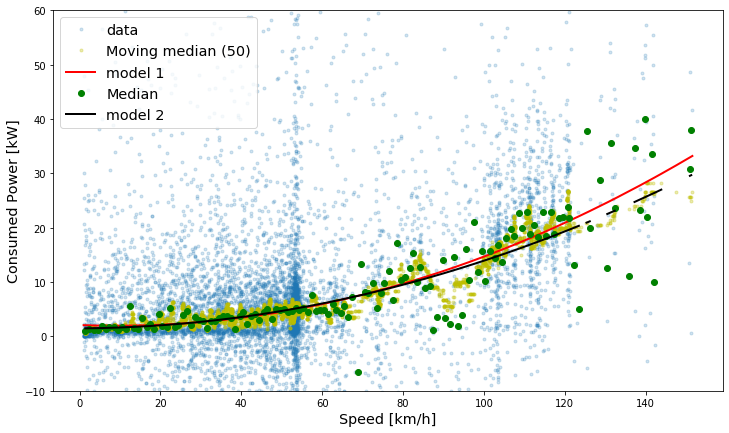

In [6]:
# model 1 moving median 
x1 = HyundaiDriveCurve.data.Speed
y1 = HyundaiDriveCurve.data.PowerConsumptionNet

ma=50
y1_med = y1.rolling(ma).median()
model1 = HyundaiDriveCurve.EfficiencyCurveModel(method='rolling')

# model 2 median
x2 = medians.Speed
y2 = medians.PowerConsumptionNet

model2 = HyundaiDriveCurve.EfficiencyCurveModel(method='median')

#plot consumed power vs. speed
plt.figure(figsize=(12,7))
plt.plot(x1, y1, '.', alpha = 0.2, label= 'data')
plt.plot(x1, y1_med, '.',alpha=0.3,  c='y', label= 'Moving median ({})'.format(ma))
plt.plot(x1, model1(x1), c='red', lw=2,label= 'model 1')
plt.plot(x2, y2, 'o', c='g', label= 'Median')
plt.plot(x2, model2(x2), c='black', lw=2,label= 'model 2')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylabel('Consumed Power [kW]', fontsize='x-large')
plt.ylim(-10,60)
plt.legend(fontsize='x-large');    

### Battery consumption per 100 km

Now that we have a model that describes the relationship between consumed power and vehicle velocity we can go one step further and determine the power consumption of the vehicle.

The power consumption is defined as follows:

<center>
$$\text{Consumption}  \left[\frac{kWh}{100 km} \right]= \frac{\text{Consumed Power}}{\text{Velocity}}\times100$$
</center>

Therefore, with our model, we can estimate the Battery consumption at a given velocity. In this way we can, for instance, determine at which velocity we need to drive so that the consumption is minimum, i.e., high energy efficiency. 

In the figure below, the Energy consumption vs. velocity of the Hyundai ioniq is presented for both models. Also the values of minimum consumption are shown.

The table below the graph shows the values of the lowest consumption and at which velocity is tis achieved. Also, the consumption at 50 km/h, 110 km/h and combined are shown. The combined values agree well the value of 13,8 kWh/100 km* provided by the manufacturer. Actually, the estimated values us slightly better.

*https://www.hyundai.de/modelle/ioniq-elektro/

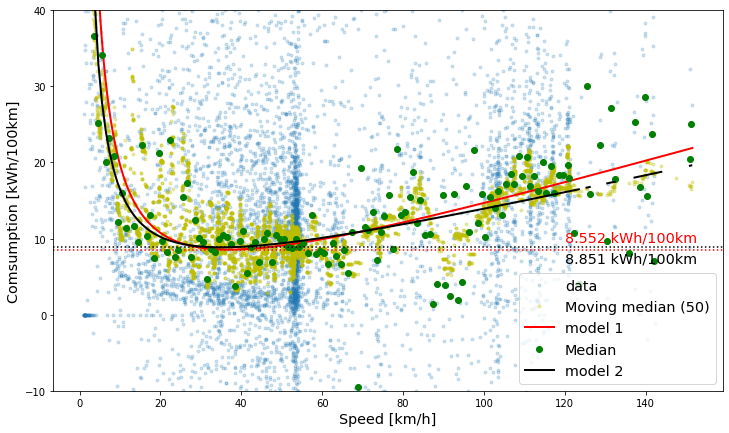

In [7]:
# get max efficiency for both models
max_eff1 = (100*model1(x1)/x1).min()
max_eff2 = (100*model2(x2)/x2).min()

#plot Efficiency vs. speed
plt.figure(figsize=(12,7))
plt.plot(x1, 100*y1/x1, '.', alpha = 0.2, label= 'data')
plt.plot(x1, 100*(y1_med/x1), '.',alpha=0.3,  c='y', label= 'Moving median ({})'.format(ma))
plt.plot(x1, 100*model1(x1)/x1, c='red', lw=2,label= 'model 1')
plt.axhline(max_eff1, c='red',ls=':')
plt.text(120,max_eff1+1, '{:.4} kWh/100km'.format(max_eff1), fontsize='x-large', c='r')
plt.plot(x2, 100*y2/x2, 'o', c='g', label= 'Median')
plt.plot(x2, 100*model2(x2)/x2, c='black', lw=2,label= 'model 2')
plt.axhline(max_eff2, c='black', ls=':')
plt.text(120,max_eff2-2, '{:.4} kWh/100km'.format(max_eff2), fontsize='x-large')
plt.ylabel('Comsumption [kWh/100km]', fontsize='x-large')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylim(-10,40)
plt.legend(fontsize='x-large');

In [8]:
from scipy import optimize
print('+'*80)
print('Model\tMin Cons.\tSpeed\tCons(50km/h)\tCons(110km/h)\tCombined Cons')
print('\t[kWh/100km]\t[km/h]\t[kWh/100km]\t[kWh/100km]\t[kWh/100km]')
print('='*80)
for i, model in enumerate([model1, model2]):
    fun = lambda x : (model[0] + model[1]*x + model[2]* x**2)*100/x
    x = optimize.minimize_scalar(fun).x
    eff50 = 100*model(50)/50
    eff110 = 100*model(110)/110
    comb = np.mean([eff50, eff110])
    print('{}\t{:.3f}\t\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(
        i+1, 100*model(x)/x, x, eff50, eff110, comb))
print('+'*80)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Model	Min Cons.	Speed	Cons(50km/h)	Cons(110km/h)	Combined Cons
	[kWh/100km]	[km/h]	[kWh/100km]	[kWh/100km]	[kWh/100km]
1	8.552		36.91	9.08		16.03		12.55
2	8.851		35.10	9.39		15.00		12.19
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Drive Range

Another important values that we can estimate, is the drive range of the battery. In other words, drive range means, how far can we drive with or vehicle at a given velocity knowing how much it consumes.
This value we learn by dividing the vehicles battery capacity by its consumption.

<center>
$$\text{Range}  \left[ km \right]= \frac{\text{Battery capacity}}{\text{Consumption}}$$
</center>

Since the battery size of the Hyundai Ioniq is 38.3 kwh (new models, the old is 28 kWh), we can, with our model, determine the drive range at all velocities.

The figure below shows, this drive range for the Ioniq determined with both models together with the values of the highest drive range.

The table below the graph shows the values of the highest range and at which velocity. Also, the ranges at 50 km/h, 110 km/h and combined are shown.

Also here, the combined value agree with the one from the one provided by the manufacturer 225 km*. From our models, these values are a bit better (241-242 km).

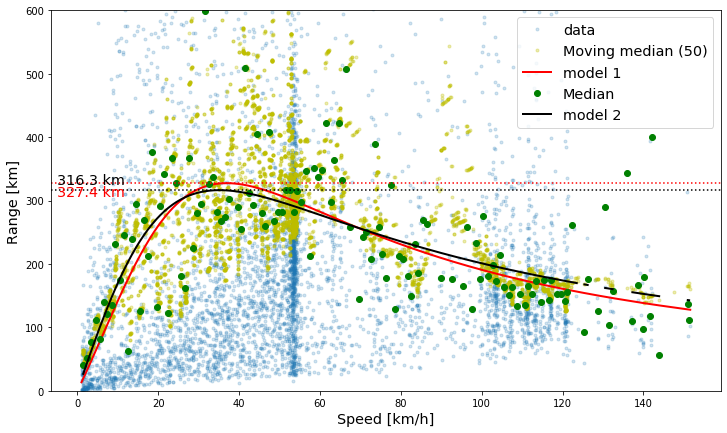

In [9]:
# battery usage from the Hyunday ioniq
battery = 28 #38.3 kWh
    
# get max range for both models
max_range1 = (battery/(model1(x1)/x1)).max()
max_range2 = (battery/(model2(x2)/x2)).max()

#plot range vs. speed
plt.figure(figsize=(12,7))
plt.plot(x1, battery/(y1/x1), '.', alpha = 0.2, label= 'data')
plt.plot(x1, battery/(y1_med/x1), '.',alpha=0.3,  c='y', label= 'Moving median ({})'.format(ma))
plt.plot(x1, battery/(model1(x1)/x1), c='red', lw=2,label= 'model 1')
plt.plot(x2, battery/(y2/x2), 'o', c='g', label= 'Median')
plt.plot(x2, battery/(model2(x2)/x2), c='black', lw=2,label= 'model 2')
plt.axhline(max_range1, c='red', ls=':')
plt.text(-5,max_range1-20, '{:.1f} km'.format(max_range1), fontsize='x-large', c='r')
plt.axhline(max_range2, c='black', ls=':')
plt.text(-5,max_range2+10, '{:.1f} km'.format(max_range2), fontsize='x-large')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylabel('Range [km]', fontsize='x-large')
plt.ylim(0,600)
plt.legend(fontsize='x-large');    

In [10]:
from scipy import optimize
print('+'*80)
print('Model\tMax Range.\tSpeed\tRange(50km/h)\tRange(110km/h)\tCombined Range')
print('\t[km]\t\t[km/h]\t[km]\t\t[km]\t\t[km]')
print('='*80)
for i, model in enumerate([model1, model2]):
    fun = lambda x : (model[0] + model[1]*x + model[2]* x**2)/x
    x = optimize.minimize_scalar(fun).x
    ra50 = battery/(model(50)/50)
    ra110 = battery/(model(110)/110)
    comb = np.mean([ra50, ra110])
    print('{}\t{:.1f}\t\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(
        i+1, battery/(model(x)/x), x, ra50, ra110, comb))
print('+'*80)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Model	Max Range.	Speed	Range(50km/h)	Range(110km/h)	Combined Range
	[km]		[km/h]	[km]		[km]		[km]
1	327.4		36.91	308.38		174.69		241.53
2	316.4		35.10	298.32		186.66		242.49
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## Vehicle Comparison

Let us now compare the driving properties of different vehicles. For this we will use model 2, the median method.

### Consumption

The figure below shows the consumption curves for a Hyundai Kona, a Kia e-Niro and a Tesla Model S, together with the Ioniq we have been discussing so far. From the figure one can observe that, the Ioniq is the most efficient through all velocities. The Kia e-Niro, is more efficient than the Kona and the Tesla at low velocities (below 30 km/h). Above these velocities, is the e-Niro much less efficient than the others. 

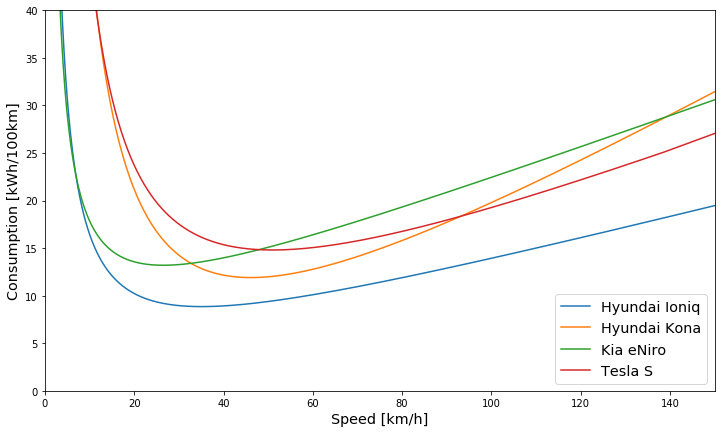

In [11]:
#########################################
#Collect data from other cars

#load kia data
kia = load_base2_ftp('ecu_bcddc2d0718c')
kia = kia[kia.model == 'KIAENIRO']

#select drive data, for kia the conditions are as below
mask = (kia.speed > 1) & (kia.hvBatteryCurrent != 1)

kia_drives = collect_drives(kia[mask])

# instantiate the ChargingCurve object
KiaDriveCurve = DriveCurve(kia_drives)

#load tesla data
tesla = load_base2_ftp('ecu_bcddc2ceb734')
tesla = tesla[tesla.model == 'TESLA_S']

#select Drive data, for Tesla the conditions are as below
mask = (tesla.speed > 1) & (tesla.hvBatteryCurrent != 1)

#collect all data for each charging curve at store it as AutoCharge() objects
tesla_drives = collect_drives(tesla[mask])

# instantiate the ChargingCurve object
TeslaDriveCurve = DriveCurve(tesla_drives)

#load Hyundai Ikona data
kona = load_base2_ftp('ecu_bcddc2d0718c')
kona = kona[kona.model == 'HYUNDAIKONA']

#select drive data, for kia the conditions are as below
mask = (kona.speed > 1) & (kona.hvBatteryCurrent != 1)

kona_drives = collect_drives(kona[mask])

# instantiate the ChargingCurve object
KonaDriveCurve = DriveCurve(kona_drives)
#########################################

# model 2 median 
hyundai_x = HyundaiDriveCurve.data.Speed
hyundai_y = HyundaiDriveCurve.EfficiencyCurveModel(method='median')(hyundai_x)

kia_x = KiaDriveCurve.data.Speed
kia_y = KiaDriveCurve.EfficiencyCurveModel(method='median')(kia_x)

tesla_x = TeslaDriveCurve.data.Speed
tesla_y = TeslaDriveCurve.EfficiencyCurveModel(method='median')(tesla_x)*-1

kona_x = KonaDriveCurve.data.Speed
kona_y = KonaDriveCurve.EfficiencyCurveModel(method='median')(kona_x)

#plot Efficiency vs. speed
plt.figure(figsize=(12,7))
plt.plot(hyundai_x, 100*hyundai_y/hyundai_x,label= 'Hyundai Ioniq')
plt.plot(kona_x, 100*kona_y/kona_x, label= 'Hyundai Kona')
plt.plot(kia_x, 100*kia_y/kia_x, label= 'Kia eNiro')
plt.plot(tesla_x, 100*tesla_y/tesla_x, label= 'Tesla S')
plt.ylabel('Consumption [kWh/100km]', fontsize='x-large')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylim(0,40)
plt.xlim(0,150)
plt.legend(fontsize='x-large');

The table below shows the Minimum consumption at 50km/h (City), 110km/h (Highway) and combined, together with the nominal values provided by the manufacturer**. 

When comparing the nominal values with the ones we have determined, we see that these are, within error bars,  very close. For the Tesla and the Ioniq, these values are actually better. However, as mentioned already, these values are within error bars, comparable.

**https://ev-database.org/

In [16]:
# Usable batteries
autos = {'Hyundai Ioniq':{'batt':28, #38.3,
                          'model':HyundaiDriveCurve.EfficiencyCurveModel(method='median'),
                          'eff':14.7,
                          'range':300,
                         },
         'Hyundai Kona':{'batt':64,
                         'model':KonaDriveCurve.EfficiencyCurveModel(method='median'),
                         'eff':16,
                         'range':460,
                         },
         'Kia eNiro':{'batt':64,
                      'model':KiaDriveCurve.EfficiencyCurveModel(method='median'),
                      'eff':17.1,
                      'range':435,
                      },
         'Tesla S ':{'batt':95,
                     'model':TeslaDriveCurve.EfficiencyCurveModel(method='median')*-1,
                     'eff':18.1,
                     'range':600,
                    }, 
        }

#generate efficiency table
print('+'*100)
print('Auto\t\tMin Cos.\tSpeed\tCos(50km/h)\tCos(110km/h)\tComb. Cos\tNom. Comb Con.')
print('\t\t[kWh/100km]\t[km/h]\t[kWh/100km]\t[kWh/100km]\t[kWh/100km]]\t[kWh/100km]')
print('='*100)
for auto in autos.keys():
    fun = lambda x : (autos[auto]['model'][0] + autos[auto]['model'][1]*x + autos[auto]['model'][2]* x**2)/x
    x = optimize.minimize_scalar(fun).x
    eff50 = 100*autos[auto]['model'](50)/50
    eff110 = 100*autos[auto]['model'](110)/110
    comb = np.mean([eff50, eff110])
    print('{}\t{:.3f}\t\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{}'.format(
        auto, 100*autos[auto]['model'](x)/x, x, eff50, eff110, comb, autos[auto]['eff']))
print('+'*100)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Auto		Min Cos.	Speed	Cos(50km/h)	Cos(110km/h)	Comb. Cos	Nom. Comb Con.
		[kWh/100km]	[km/h]	[kWh/100km]	[kWh/100km]	[kWh/100km]]	[kWh/100km]
Hyundai Ioniq	8.851		35.10	9.39		15.00		12.19		14.7
Hyundai Kona	11.902		46.13	11.98		21.97		16.98		16
Kia eNiro	13.197		26.50	15.09		24.04		19.56		17.1
Tesla S 	14.802		50.98	14.81		20.68		17.74		18.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Drive Range 

What about the drive range? The Tesla hast the highest value with a maximal drive rage of 641.8 km at a velocity of 51 km/h. Nevertheless, he combined value is a bit lower than the nominal (see table below). O the other hand, the Ioniq has the lowest drive range, its combined values is larger than the nominal, though.

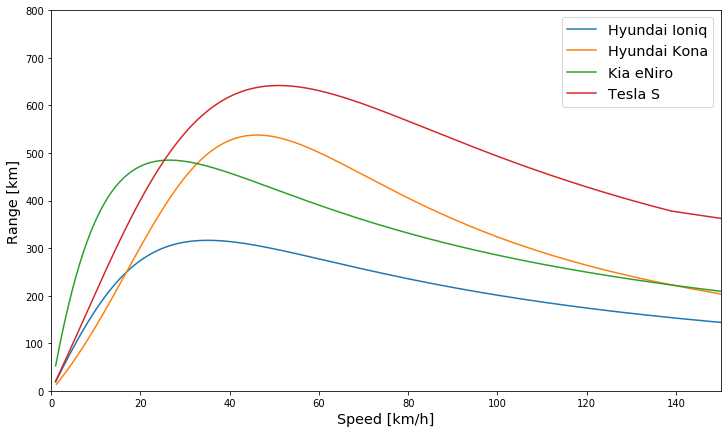

In [13]:
hyundai_batt = autos['Hyundai Ioniq']['batt']
kona_batt = autos['Hyundai Kona']['batt']
kia_batt = autos['Kia eNiro']['batt']
tesla_batt = autos['Tesla S ']['batt'] 

#plot range vs. speed
plt.figure(figsize=(12,7))
plt.plot(hyundai_x, hyundai_batt/(hyundai_y/hyundai_x),label= 'Hyundai Ioniq')
plt.plot(kona_x, kona_batt/(kona_y/kona_x), label= 'Hyundai Kona')
plt.plot(kia_x, kia_batt/(kia_y/kia_x), label= 'Kia eNiro')
plt.plot(tesla_x, tesla_batt/(tesla_y/tesla_x), label= 'Tesla S')
plt.ylabel('Range [km]', fontsize='x-large')
plt.xlabel('Speed [km/h]', fontsize='x-large')
plt.ylim(0,800)
plt.xlim(0,150)
plt.legend(fontsize='x-large');

In [14]:
#generate range table
print('+'*100)
print('Auto\t\tMax Range.\tSpeed\tRange(50km/h)\tRange(110km/h)\tComb. Range\tNom. Comb. Range')
print('\t\t[km]\t\t[km/h]\t[km]\t\t[km]\t\t[km]\t\t[km]')
print('='*100)
for auto in autos.keys():
    fun = lambda x : (autos[auto]['model'][0] + autos[auto]['model'][1]*x + autos[auto]['model'][2]* x**2)/x
    x = optimize.minimize_scalar(fun).x
    ra50 = autos[auto]['batt']/(autos[auto]['model'](50)/50)
    ra110 = autos[auto]['batt']/(autos[auto]['model'](110)/110)
    comb = np.mean([ra50, ra110])
    print('{}\t{:.1f}\t\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{}'.format(
        auto, autos[auto]['batt']/(autos[auto]['model'](x)/x), x, ra50, ra110, comb, autos[auto]['range']))
print('+'*100)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Auto		Max Range.	Speed	Range(50km/h)	Range(110km/h)	Comb. Range	Nom. Comb. Range
		[km]		[km/h]	[km]		[km]		[km]		[km]
Hyundai Ioniq	316.4		35.10	298.32		186.66		242.49		300
Hyundai Kona	537.7		46.13	534.06		291.26		412.66		460
Kia eNiro	485.0		26.50	424.26		266.26		345.26		435
Tesla S 	641.8		50.98	641.67		459.39		550.53		600
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## Summary

In this notebook we have estimated several important drive properties like Energy consumption and drive range with help of real drive data.

We have discussed two different methods to simplify the real data in order to fit a mathematical model that we can use to determine the correlation between consumed power and vehicles velocity.

This model allows us to determine the energy consumption of the vehicle and its drive range at a given velocity.

Moreover, we have compare the battery consumption and drive range between different vehicles. We have also, compared our determined values with those provided by the manufacturers, and have found that both agree well within error bars.

In the future, we will refine this model so that important drive conditions can be included such as temperature, altitude, etc.

In [15]:
def getMedianBins(df):
    """
    Function to determine the median value at a constant speed, by aggregating
    the power values in 1 km/h speed bins.
    
    Returns a panda DataFrame with median values of Speed, PowerConsumption, 
    PowerNet at 1 km/h bins.
    """
    
    bins = pd.IntervalIndex.from_tuples([(i, i+1)  for i in range(152)])
    
    dff = df[['Speed', 'PowerConsumption', 'PowerGain']]
    dff['PowerNet'] = dff['PowerConsumption'] - dff['PowerGain']
    dff['ranges'] = pd.cut(dff.Speed, bins = bins)

    medians = dff.groupby('ranges').median()
    #medians['speed'] = np.arange(0,152,1)
    
    return medians

def EffCurve(df,degree, ma, power='net'):
    """
    Compares and plots polynomial fit models of the Battery consupmtion vs Speed
    
    Returns plots of Power vs Speed, Efficiency vs Speed and Range vs Speed.
    """
    medians = getMedianBins(df)
    
    if power == 'net':
        x = df.Speed
        y = df.PowerConsumption - df.PowerGain
        y1 = y.rolling(ma).median()

        mask = np.isfinite(medians.Speed) #mask to remove NaN values
        
        x2 = medians.Speed[mask]
        y2 = medians.PowerNet[mask]
    else:
        mask1 = df.PowerConsumption != 0 # avoids influence from power zero-values (artificial data)
        x = df.Speed[mask1]
        y = df.PowerConsumption[mask1] 
        y1 = y.rolling(ma).median()

        #fit model using the median values at constants speed
        mask = np.isfinite(medians.Speed) & medians.PowerConsumption !=0
        x2 = medians.Speed[mask]
        y2 = medians.PowerConsumption[mask]

       
    #fit model using moving median with a ma period window
    pol1 = np.polyfit(x.iloc[ma:], y1[ma:], deg=degree, full=True)
    model1 = np.poly1d(pol1[0])
    
    #fit model using the median values at constants speed
    pol2 = np.polyfit(x2, y2, deg=degree, full=True)
    model2 = np.poly1d(pol2[0])
    
    # battery usage from the Hyunday ioniq
    battery = 38.3 #kWh

    max_eff1 = (100*model1(x)/x).min()
    max_range1 = (battery/(model1(x)/x)).max()
    
    max_eff2 = (100*model2(x2)/x2).min()
    max_range2 = (battery/(model2(x2)/x2)).max()

    #print the fitted model and its residuals  
    print('Model1:\n{}\n\nResidual1: {}'.format(model1,pol1[1][0]))
    print('\nModel2:\n{}\n\nResidual2: {}'.format(model2,pol2[1][0]))
    
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,15))
    plt.cla()
    
    #plot consumed power vs. speed
    ax1.plot(x, y, '.', alpha = 0.2, label= 'data')
    ax1.plot(x, y1, '.',alpha=0.3,  c='y', label= 'Moving median ({})'.format(ma))
    ax1.plot(x, model1(x), c='red', lw=2,label= 'model 1')
    ax1.plot(x2, y2, 'o', c='g', label= 'Median')
    ax1.plot(x2, model2(x2), c='black', lw=2,label= 'model 2')
    ax1.set_ylabel('Consumed Power [kW]', fontsize='x-large')
    ax1.set_ylim(-10,60)
    ax1.legend(fontsize='x-large')
    
    #plot Efficiency vs. speed
    ax2.plot(x, 100*y/x, '.', alpha = 0.2, label= 'data')
    ax2.plot(x, 100*(y1/x), '.',alpha=0.3,  c='y', label= 'Moving median ({})'.format(ma))
    ax2.plot(x, 100*model1(x)/x, c='red', lw=2,label= 'model 1')
    ax2.axhline(max_eff1, c='red',ls=':')
    ax2.text(120,max_eff1+1, '{:.4} kWh/100km'.format(max_eff1), fontsize='x-large', c='r')
    ax2.plot(x2, 100*y2/x2, 'o', c='g', label= 'Median')
    ax2.plot(x2, 100*model2(x2)/x2, c='black', lw=2,label= 'model 2')
    ax2.axhline(max_eff2, c='black', ls=':')
    ax2.text(120,max_eff2-2, '{:.4} kWh/100km'.format(max_eff2), fontsize='x-large')
    ax2.set_ylabel('Efficiency [kWh/100km]', fontsize='x-large')
    ax2.set_ylim(-10,40)
    
    #plot range vs. speed
    ax3.plot(x, battery/(y/x), '.', alpha = 0.2, label= 'data')
    ax3.plot(x, battery/(y1/x), '.',alpha=0.8,  c='y', label= 'Moving median ({})'.format(ma))
    ax3.plot(x, battery/(model1(x)/x), c='red', lw=2,label= 'model 1')
    ax3.axhline(max_range1, c='red', ls=':')
    ax3.text(-5,max_range1-20, '{:.1f} km'.format(max_range1), fontsize='x-large', c='r')
    ax3.plot(x2, battery/(y2/x2), 'o', c='g', label= 'Median')
    ax3.plot(x2, battery/(model2(x2)/x2), c='black', lw=2,label= 'model 2')
    ax3.axhline(max_range2, c='black', ls=':')
    ax3.text(-5,max_range2+10, '{:.1f} km'.format(max_range2), fontsize='x-large')
    ax3.set_ylabel('Range [km]', fontsize='x-large')
    ax3.set_ylim(0,600)
    plt.xlabel('Speed [km/h]', fontsize='x-large')
    plt.tight_layout()

interact(EffCurve, df = fixed(HyundaiDriveCurve.data), degree = (0,4,1),ma = (50, 200, 50), power=['net', 'consumption']);

interactive(children=(IntSlider(value=2, description='degree', max=4), IntSlider(value=100, description='ma', …